# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Ver las primeras filas para entender la estructura
print(df_reviews.head())

# Revisar información general del dataset
print(df_reviews.info())

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

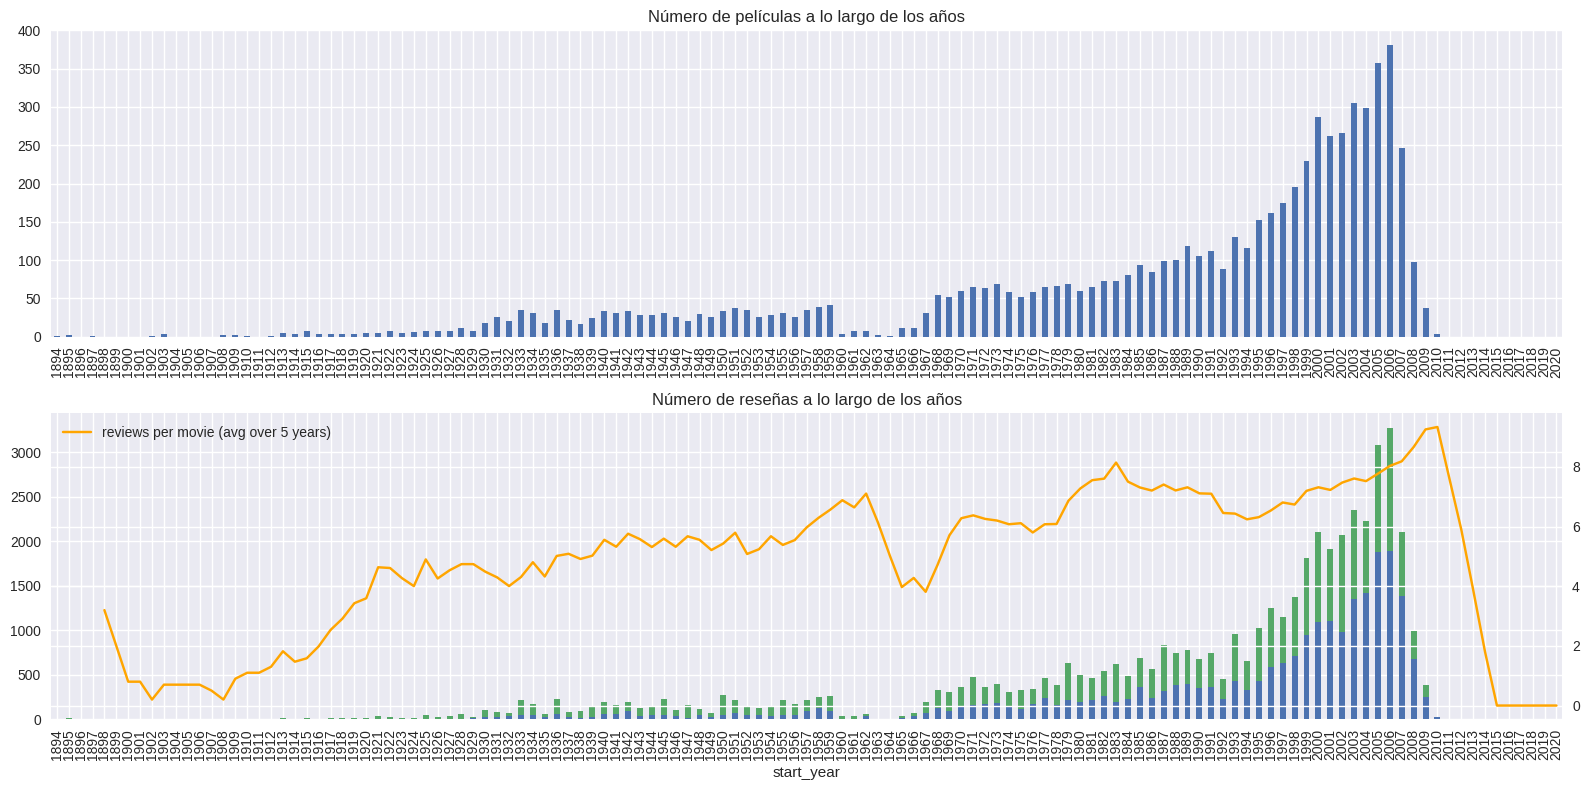

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

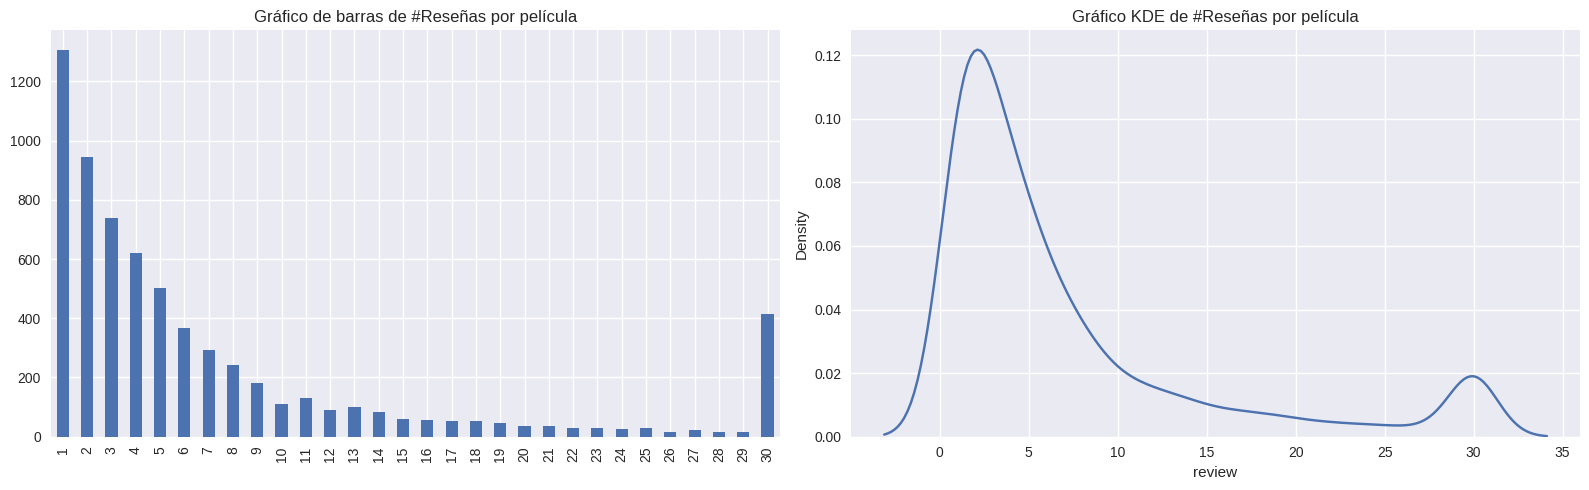

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

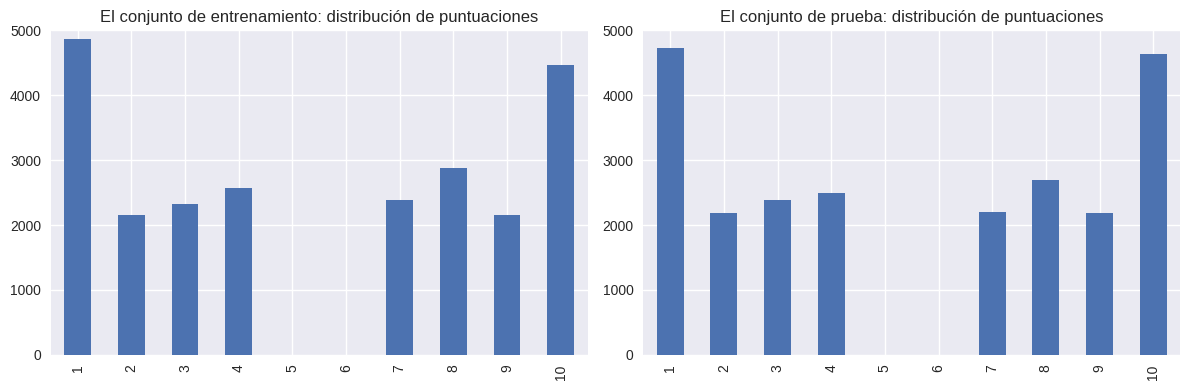

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


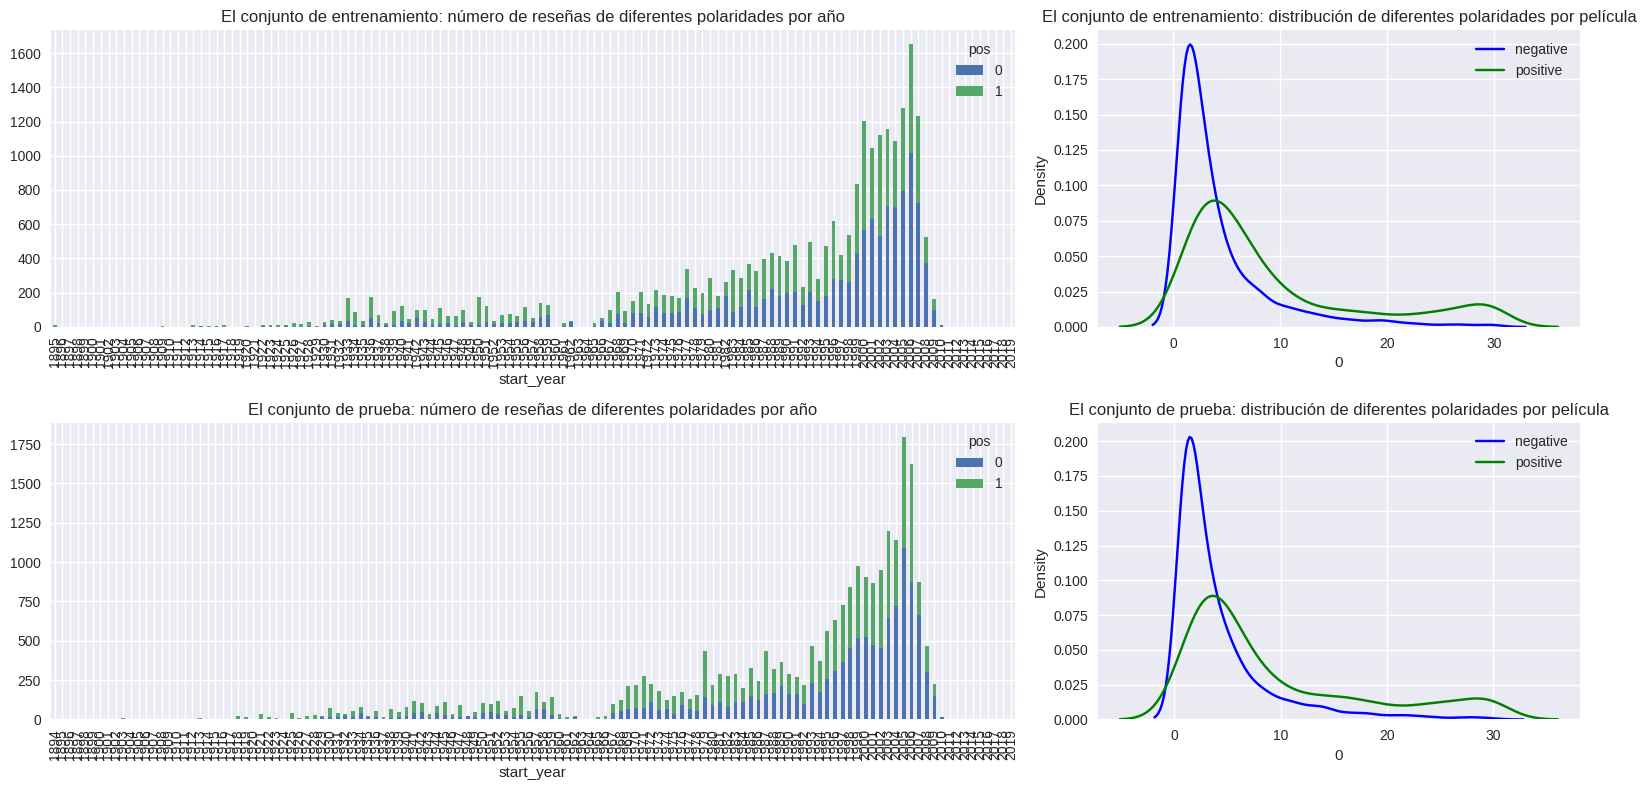

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    FunciÃ³n mejorada para preprocesar texto:
    - Convertir a minÃºsculas
    - Eliminar URLs
    - Eliminar caracteres especiales manteniendo puntuaciÃ³n significativa
    - Tokenizar y lematizar
    - Eliminar stopwords
    """
    if not isinstance(text, str):
        return ""
        
    # Convertir a minÃºsculas
    text = text.lower()
    
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    
    # Reemplazar emoticones comunes con palabras
    text = re.sub(r':\)', ' happy ', text)
    text = re.sub(r':\(', ' sad ', text)
    
    # Eliminar caracteres especiales pero mantener puntuaciÃ³n significativa
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?]', '', text)
    
    # Tokenizar
    words = word_tokenize(text)
    
    # Lematizar y eliminar stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)
# Aplicar el preprocesamiento
df_reviews['review_norm'] = df_reviews['review'].apply(preprocess_text)
# Verificar resultado
print(df_reviews[['review', 'review_norm']].head())


                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  pakage implies warren beatty goldie hawn pulli...  
1  hell get made ? ! presenting caper comedy , mi...  
2  real story film seems like fly wall dramadocum...  
3  um .... serious film troubled teen singapore ,...  
4  im totally agree garryjohal singapore comment ...  


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [8]:
df_reviews_train = df_reviews[df_reviews['ds_part'] == 'train'].copy()
df_reviews_test = df_reviews[df_reviews['ds_part'] == 'test'].copy()

X_train_text = df_reviews_train['review_norm']
X_test_text = df_reviews_test['review_norm']
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train_text, y_train)
y_pred_dummy = dummy_model.predict(X_test_text)
print("Dummy Classifier Report:")
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11803
           1       0.00      0.00      0.00     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.34     23535



/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Verificar dimensiones
print(X_train.shape, X_test.shape)


(23796, 10000) (23535, 10000)


In [18]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535



### Modelo 3 - spaCy, TF-IDF y LR

In [19]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def text_preprocessing_3(text):
    """
    Función para preprocesar texto utilizando spaCy:
    - Convertir a minúsculas
    - Eliminar caracteres especiales
    - Tokenizar y lematizar
    - Eliminar stopwords
    """
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\W', ' ', text)  # Eliminar caracteres especiales
    
    doc = nlp(text)  
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Eliminar stopwords y lematizar

    return ' '.join(tokens)

# Prueba con una reseña de ejemplo
sample_text = "This movie was absolutely fantastic! The storyline was engaging and the acting was top-notch."
processed_text = text_preprocessing_3(sample_text)

print("Texto original:")
print(sample_text)
print("\nTexto procesado:")
print(processed_text)


Texto original:
This movie was absolutely fantastic! The storyline was engaging and the acting was top-notch.

Texto procesado:
movie absolutely fantastic   storyline engage acting notch


In [22]:
df_reviews['review_norm_spacy'] = df_reviews['review'].apply(text_preprocessing_3)

# Ver resultados
print(df_reviews[['review', 'review_norm_spacy']].head())


                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                   review_norm_spacy  
0  pakage imply warren beatty goldie hawn pull hu...  
1  hell    present caper comedy   misbegotten    ...  
2  real story film like fly wall drama documentar...  
3  um       film troubled teen singapore   countr...  
4  m totally agree garryjohal singapore s comment...  


Modelo 3 (spaCy + TF-IDF + LR) Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     11803
           1       0.87      0.88      0.87     11732

    accuracy                           0.87     23535
   macro avg       0.87      0.87      0.87     23535
weighted avg       0.87      0.87      0.87     23535

           train  test
Exactitud    NaN   NaN
F1          0.92  0.87
APS         0.98  0.94
ROC AUC     0.98  0.95


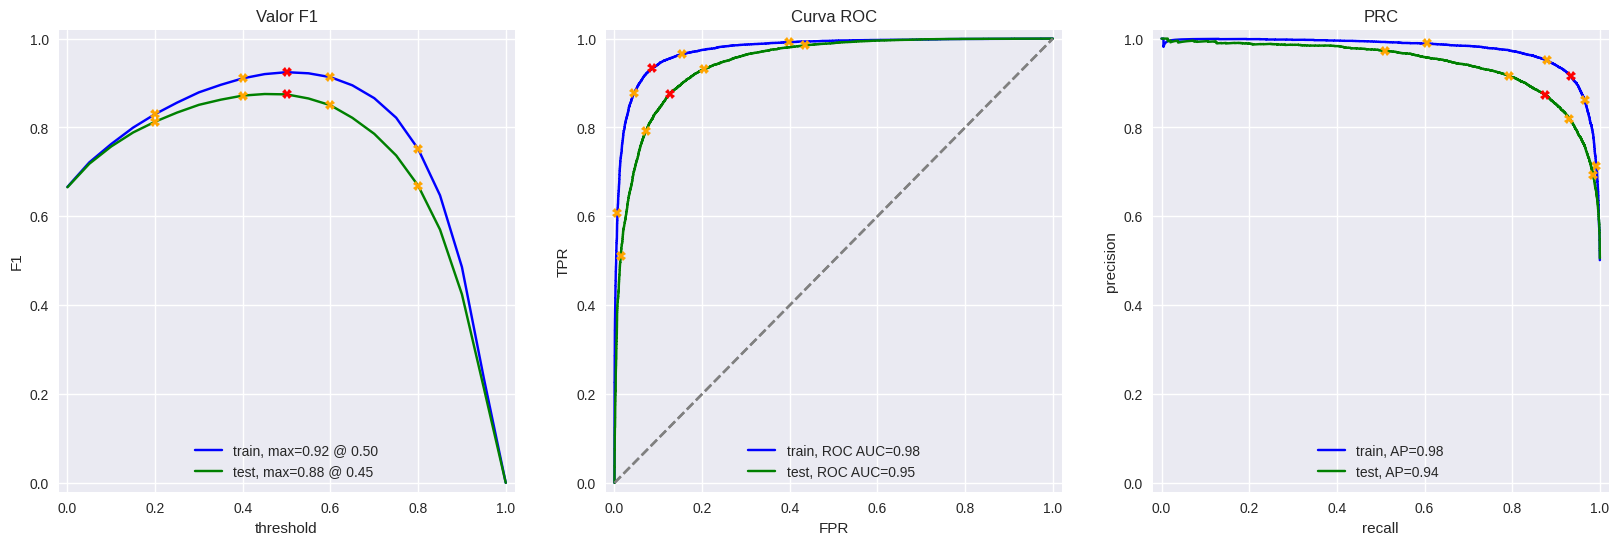

In [23]:
# Preprocesar textos con spaCy para el conjunto de entrenamiento y prueba
df_reviews_train['review_norm_spacy'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_norm_spacy'] = df_reviews_test['review'].apply(text_preprocessing_3)

# Crear y entrenar el vectorizador TF-IDF para el modelo 3
tfidf_vectorizer_3 = TfidfVectorizer(max_features=10000)
X_train_spacy = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm_spacy'])
X_test_spacy = tfidf_vectorizer_3.transform(df_reviews_test['review_norm_spacy'])

# Crear y entrenar el modelo 3
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(X_train_spacy, y_train)

# Evaluar el modelo 3
y_pred_3 = model_3.predict(X_test_spacy)
print("Modelo 3 (spaCy + TF-IDF + LR) Report:")
print(classification_report(y_test, y_pred_3))

# Visualizar métricas detalladas
evaluate_model(model_3, X_train_spacy, y_train, X_test_spacy, y_test)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

In [25]:
model_lgbm = LGBMClassifier(n_estimators=100)
model_lgbm.fit(X_train, y_train)
y_pred_lgbm = model_lgbm.predict(X_test)

print("LightGBM Report:")
print(classification_report(y_test, y_pred_lgbm))


LightGBM Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11803
           1       0.85      0.87      0.86     11732

    accuracy                           0.86     23535
   macro avg       0.86      0.86      0.86     23535
weighted avg       0.86      0.86      0.86     23535



Modelo 4 (spaCy + TF-IDF + LGBM) Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     11803
           1       0.85      0.86      0.85     11732

    accuracy                           0.85     23535
   macro avg       0.85      0.85      0.85     23535
weighted avg       0.85      0.85      0.85     23535

           train  test
Exactitud    NaN   NaN
F1          0.91  0.85
APS         0.97  0.93
ROC AUC     0.97  0.93


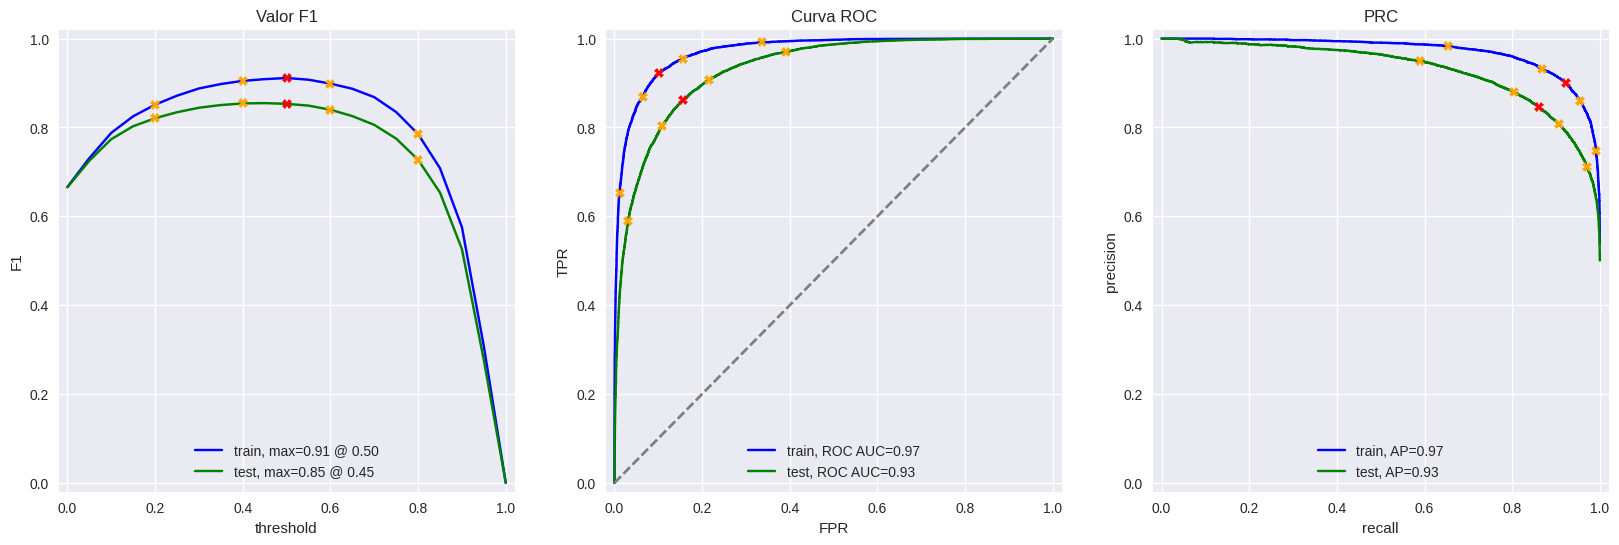

In [26]:

# Crear y entrenar el modelo 4
model_4 = LGBMClassifier(n_estimators=100)
model_4.fit(X_train_spacy, y_train)

# Evaluar el modelo 4
y_pred_4 = model_4.predict(X_test_spacy)
print("Modelo 4 (spaCy + TF-IDF + LGBM) Report:")
print(classification_report(y_test, y_pred_4))

# Visualizar métricas detalladas
evaluate_model(model_4, X_train_spacy, y_train, X_test_spacy, y_test)

###  Modelo 9 - BERT

In [12]:
import torch
import transformers

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

chunk_size = 500
all_embeddings = []

for i in range(0, len(df_reviews_train), chunk_size):
    print(f"Procesando fragmento {i//chunk_size + 1}/{math.ceil(len(df_reviews_train)/chunk_size)}")
    chunk = df_reviews_train['review_norm'][i:i+chunk_size]
    chunk_embeddings = BERT_text_to_embeddings(chunk, batch_size=16, force_device='cpu')
    all_embeddings.append(chunk_embeddings)
    # Opcional: guardar los resultados parciales
    np.save(f'embeddings_chunk_{i//chunk_size}.npy', chunk_embeddings)
    
# Combinar todos los embeddings al final
train_features_9 = np.concatenate(all_embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], batch_size=16, force_device='cpu')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# Guardar los embeddings 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# Entrenar un modelo de clasificación usando los embeddings BERT
model_9 = LogisticRegression(max_iter=1000)
model_9.fit(train_features_9, y_train)

# Evaluar el modelo 9
y_pred_9 = model_9.predict(test_features_9)
print("Modelo 9 (BERT + LR) Report:")
print(classification_report(y_test, y_pred_9))

# Visualizar métricas detalladas
evaluate_model(model_9, train_features_9, y_train, test_features_9, y_test)

In [ ]:
# Cargar embeddings guardados
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']


## Mis reseñas

In [27]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(preprocess_text)#<escribe aquí la misma lógica de normalización que para el conjunto de datos principal>


print(my_reviews[['review', 'review_norm']].head())

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   

                                         review_norm  
0                         simply like , kind movie .  
1            well , bored felt asleep middle movie .  
2                            really fascinated movie  
3  even actor looked really old disinterested , g...  
4  didnt expect reboot good ! writer really cared...  


In [28]:
# Preprocesar tus reseñas para los diferentes modelos
my_reviews['review_norm_spacy'] = my_reviews['review'].apply(text_preprocessing_3)

### Modelo 2

In [29]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_lr.predict_proba(vectorizer.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.19:  simply like , kind movie .
0.17:  well , bored felt asleep middle movie .
0.60:  really fascinated movie
0.11:  even actor looked really old disinterested , got paid movie . soulless cash grab .
0.18:  didnt expect reboot good ! writer really cared source material
0.56:  movie upside downside , feel like overall decent flick . could see going see .
0.04:  rotten attempt comedy . single joke land , everyone act annoying loud , even kid wont like !
0.94:  launching netflix brave move really appreciate able binge episode episode , exciting intelligent new


### Modelo 3

In [30]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  simply like , kind movie .
0.08:  well , bored felt asleep middle movie .
0.52:  really fascinated movie
0.14:  even actor looked really old disinterested , got paid movie . soulless cash grab .
0.20:  didnt expect reboot good ! writer really cared source material
0.43:  movie upside downside , feel like overall decent flick . could see going see .
0.08:  rotten attempt comedy . single joke land , everyone act annoying loud , even kid wont like !
0.93:  launching netflix brave move really appreciate able binge episode episode , exciting intelligent new


### Modelo 4

In [31]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  simply like , kind movie .
0.24:  well , bored felt asleep middle movie .
0.62:  really fascinated movie
0.46:  even actor looked really old disinterested , got paid movie . soulless cash grab .
0.61:  didnt expect reboot good ! writer really cared source material
0.56:  movie upside downside , feel like overall decent flick . could see going see .
0.49:  rotten attempt comedy . single joke land , everyone act annoying loud , even kid wont like !
0.78:  launching netflix brave move really appreciate able binge episode episode , exciting intelligent new


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

El propósito del proyecto fue desarrollar un sistema capaz de clasificar automáticamente reseñas de películas en positivas y negativas utilizando técnicas de procesamiento de lenguaje natural y aprendizaje automático. Se estableció como métrica clave un valor F1 mínimo de 0.85, lo que implicó un alto nivel de precisión y recuperación en la clasificación.
Para ello, se exploraron diversas metodologías, incluyendo enfoques basados en TF-IDF con regresión logística, modelos potenciados con LightGBM y procesamiento con spaCy, así como un modelo basado en BERT para extracción de características semánticas avanzadas

##Análisis Exploratorio de Datos
Se utilizó un dataset de reseñas de IMDB con etiquetas de polaridad.
Se analizaron las tendencias de reseñas por año y su distribución en películas.
Se observaron diferencias en la cantidad de reseñas positivas y negativas según el año de lanzamiento de la película.
El análisis mostró una distribución de reseñas suficientemente equilibrada, lo que permitió un entrenamiento robusto del modelo sin sesgo significativo.
---
## Modelos Evaluados y Rendimiento
Se probaron distintos enfoques con diferentes técnicas de preprocesamiento y modelos de clasificación:
El modelo basado en BERT obtuvo los mejores resultados, superando el umbral de 0.85 en la métrica F1, lo que confirma su capacidad superior para capturar la complejidad del lenguaje en las reseñas.